2021년 10월 9일에 마지막으로 테스트하였습니다.  

이 자료는 '위키독스 딥 러닝을 이용한 자연어 처리 입문, 네이버 영화 리뷰 튜토리얼입니다.'

링크 : https://wikidocs.net/44249

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 29.1 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [61]:
from google.colab import files

traindata = files.upload()
testdata = files.upload()
font= files.upload()
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
#urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

Saving 웰컴체 Regular.ttf to 웰컴체 Regular.ttf


In [62]:
train_data = pd.read_table('TrainData.txt')
test_data = pd.read_table('TestData.txt')

print(train_data)

      id                                           document  label
0    367                    국민의힘 36% vs 민주당 34%…격차 8%p→2%p로    0.0
1    203               [영상]백신 부작용 공론화에도 "문재인과 정은경은 사과도 없어?"    1.0
2    601                       퇴근했는데 업무 전화·이메일...포르투갈선 처벌된다    0.0
3    412                 [이슈폴폴] 여론조사로 풀어 보는 정치…11월 둘째주 민심은?    0.0
4    669  [1112퇴근길] 셀트리온 '렉키로나' 유럽·아시아·중남미 30여개국 판매 협상 외...    0.0
..   ...                                                ...    ...
667  801                       호주 산불로 코알라 2000마리가 죽었을지도 모른다    1.0
668  802                       산불에 태풍까지 '난리통'…산불 이재민 "가혹하다"    1.0
669  803                     김지민, 강원도 산불 피해에 "비통하다"..참담한 심경    1.0
670  804                                    전국 태풍급 강풍과 눈 예보    1.0
671  805                        경북, 태풍 '마이삭·하이선' 피해 1154억 원    1.0

[672 rows x 3 columns]


In [63]:
print('훈련 샘플의 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 672
테스트 샘플의 개수 : 93


In [64]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,367,국민의힘 36% vs 민주당 34%…격차 8%p→2%p로,0.0
1,203,"[영상]백신 부작용 공론화에도 ""문재인과 정은경은 사과도 없어?""",1.0
2,601,퇴근했는데 업무 전화·이메일...포르투갈선 처벌된다,0.0
3,412,[이슈폴폴] 여론조사로 풀어 보는 정치…11월 둘째주 민심은?,0.0
4,669,[1112퇴근길] 셀트리온 '렉키로나' 유럽·아시아·중남미 30여개국 판매 협상 외...,0.0


In [65]:
train_data['document'].nunique(), train_data['label'].nunique()

(489, 2)

In [66]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [67]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 489


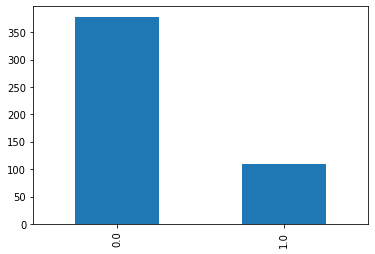

In [68]:
train_data['label'].value_counts().plot(kind = 'bar')

In [69]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0    0.0    378
1    1.0    109


In [70]:
print(train_data.isnull().values.any())

True


In [71]:
print(train_data.isnull().sum())

id          0
document    0
label       2
dtype: int64


In [72]:
train_data.loc[train_data.document.isnull()]

,id,document,label


In [73]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [74]:
print(len(train_data))

487


In [75]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,document,label
0,367,국민의힘 민주당 격차 로,0.0
1,203,영상백신 부작용 공론화에도 문재인과 정은경은 사과도 없어,1.0
2,601,퇴근했는데 업무 전화이메일포르투갈선 처벌된다,0.0
3,412,이슈폴폴 여론조사로 풀어 보는 정치월 둘째주 민심은,0.0
4,669,퇴근길 셀트리온 렉키로나 유럽아시아중남미 여개국 판매 협상 외 경제금융뉴스 부터 인...,0.0


In [76]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [77]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label


In [78]:
train_data = train_data.dropna(how = 'any')

In [79]:
print(len(train_data))

487


In [80]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 89


In [81]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 89


In [82]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [83]:
okt = Okt()

In [84]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 487/487 [00:01<00:00, 280.69it/s]


In [85]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 89/89 [00:00<00:00, 583.47it/s]


In [86]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 89


In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [88]:
print(tokenizer.word_index)

{'이재명': 1, '년': 2, '요': 3, '소수': 4, '명': 5, '서': 6, '윤석열': 7, '로': 8, '만': 9, '백신': 10, '코로나': 11, '주': 12, '등': 13, '국민': 14, '정부': 15, '다': 16, '밉다': 17, '제': 18, '안': 19, '대다': 20, '없다': 21, '되다': 22, '나': 23, '것': 24, '시진핑': 25, '시간': 26, '중': 27, '공개': 28, '더': 29, '일': 30, '원': 31, '이준석': 32, '부터': 33, '중국': 34, '적': 35, '단독': 36, '대표': 37, '최': 38, '의혹': 39, '있다': 40, '민주당': 41, '뉴스': 42, '선언': 43, '개': 44, '원전': 45, '에서': 46, '지': 47, '아니다': 48, '대선': 49, '김': 50, '수': 51, '만에': 52, '연': 53, '여성': 54, '공': 55, '억': 56, '또': 57, '유럽': 58, '경제': 59, '대통령': 60, '조사': 61, '신': 62, '엔': 63, '모': 64, '바이든': 65, '당': 66, '전': 67, '성': 68, '권': 69, '검찰': 70, '테슬라': 71, '세': 72, '주유소': 73, '확진': 74, '증': 75, '전국': 76, '한국': 77, '판매': 78, '인': 79, '종전': 80, '사설': 81, '가족': 82, '원금': 83, '고': 84, '대장동': 85, '받다': 86, '차관': 87, '내': 88, '오늘': 89, '우리': 90, '위중': 91, '맞다': 92, '김종인': 93, '확보': 94, '힘': 95, '이슈': 96, '한미': 97, '간': 98, '않다': 99, '법원': 100, '사망': 101, '신고': 102, '경찰': 103, '보

In [89]:
print(tokenizer.word_counts.items())

odict_items([('국민', 17), ('힘', 7), ('민주당', 11), ('격차', 3), ('로', 23), ('영상', 5), ('백신', 21), ('부작용', 2), ('공론', 1), ('화', 5), ('에도', 2), ('문재인', 1), ('정은경', 2), ('사과', 4), ('없다', 14), ('퇴근', 3), ('업무', 3), ('전화', 1), ('이메일', 1), ('포르투갈', 1), ('선', 6), ('처벌', 1), ('되다', 14), ('이슈', 7), ('폴폴', 1), ('여론조사', 1), ('풀다', 4), ('보다', 6), ('정치', 4), ('월', 6), ('둘째', 1), ('주', 18), ('민심', 3), ('퇴근길', 1), ('셀트리온', 3), ('렉', 4), ('키로', 6), ('나', 14), ('유럽', 9), ('아시아', 1), ('중남미', 1), ('여', 1), ('개국', 2), ('판매', 8), ('협상', 4), ('외', 1), ('경제', 9), ('금융', 3), ('뉴스', 11), ('부터', 12), ('인', 8), ('포스', 1), ('탁데', 1), ('일리', 1), ('문', 5), ('대통령', 9), ('회의', 6), ('서', 26), ('인증', 1), ('국제', 6), ('기준', 2), ('마련', 2), ('교류', 1), ('활성화', 1), ('제안', 1), ('이르다', 1), ('다', 16), ('죽다', 2), ('중고', 1), ('덮다', 3), ('친', 6), ('업계', 6), ('눈물', 2), ('호소', 6), ('곽상도', 4), ('의원직', 2), ('상실', 2), ('대구', 2), ('중', 13), ('남구', 1), ('재보궐', 1), ('계', 2), ('영', 3), ('끌', 3), ('윤석열', 24), ('친문', 1), ('빼다', 1), ('빅', 1), ('텐트

In [90]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2068
등장 빈도가 2번 이하인 희귀 단어의 수: 1540
단어 집합에서 희귀 단어의 비율: 74.46808510638297
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 38.740028635712825


In [91]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 529


In [92]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [93]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [94]:
print(len(X_train))
print(len(y_train))

487
487


In [95]:
print(X_train[:3])

[[14, 95, 41, 345, 8], [174, 10, 175, 247, 21], [346, 347, 123, 22]]


In [96]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [97]:
print(drop_train)

[145, 238, 409, 461]


In [98]:
len(drop_train)

4

In [99]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [100]:
print(len(X_train))
print(len(y_train))

483
483


In [101]:
print(len(X_test))
print(len(y_test))

89
89


In [102]:
X_test = np.delete(X_test, drop_test, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [103]:
y_test = np.delete(y_test, drop_test, axis=0)

In [104]:
print(len(X_test))
print(len(y_test))

88
88


기사의 최대 길이 : 13
기사의 평균 길이 : 6.200828157349896


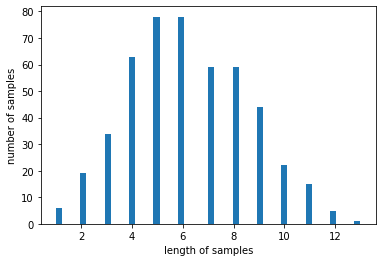

In [105]:
print('기사의 최대 길이 :',max(len(l) for l in X_train))
print('기사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [106]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [107]:
max_len = 7
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 7 이하인 샘플의 비율: 69.77225672877847


In [108]:

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [109]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [110]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [111]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [112]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 0.6086 - acc: 0.7487
Epoch 00001: val_acc improved from -inf to 0.71134, saving model to best_model.h5
7/7 [==============================] - 4s 180ms/step - loss: 0.6086 - acc: 0.7487 - val_loss: 0.7214 - val_acc: 0.7113
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.4149 - acc: 0.8264
Epoch 00002: val_acc improved from 0.71134 to 0.75258, saving model to best_model.h5
7/7 [==============================] - 0s 29ms/step - loss: 0.4149 - acc: 0.8264 - val_loss: 0.9403 - val_acc: 0.7526
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.3298 - acc: 0.8731
Epoch 00003: val_acc did not improve from 0.75258
7/7 [==============================] - 0s 25ms/step - loss: 0.3298 - acc: 0.8731 - val_loss: 0.6271 - val_acc: 0.7526
Epoch 4/15
4/7 [================>.............] - ETA: 0s - loss: 0.2532 - acc: 0.8945
Epoch 00004: val_acc improved from 0.75258 to 0.77320, saving model to best_mode

In [113]:
loaded_model = load_model('best_model.h5')

In [114]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

3/3 [==============================] - 1s 9ms/step - loss: 0.2886 - acc: 0.8977

 테스트 정확도: 0.8977


In [115]:
from collections import Counter
from wordcloud import WordCloud

file = files.upload
wc = WordCloud(font_path = '/content/웰컴체 Regular.ttf', background_color = "white", width = 1000, height = 1000, max_words = 100, max_font_size = 300)

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 재난 기사입니다.\n".format(score * 100))
    return True
  else:
    print("{:.2f}% 확률로 재난기사가 아닙니다.\n".format((1 - score) * 100))
    return False

In [116]:
from collections import Counter
def countwords(text,result):
  if(result == True):
    words = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', text)
    words = okt.morphs(words, stem=True) # 토큰화
    words = [word for word in words if not word in stopwords] # 불용어 제거
    #noun = okt.nouns(text)
    for i,v in enumerate(words):
      if( len(v) < 2):
          words.pop(i)

    count = Counter(words)
    str = " "
    noun_list = count.most_common(100)

    for v in noun_list:
      print(v)
      num = f'{v[1]}'
      #print(v[1], type(v[1]))
      str += "('" + v[0] + "'" + ", " + num + ")"
      
      wc.generate(str)
      wc.to_file('wordcloud.png')
      
    #return str
  #else:
    #return " "
      
    


In [124]:
text1 = "“하루 1만명 확진·50명 사망” 예측에…정부, 긴급의료대응계획 발표,  " 
result = sentiment_predict(text1)
string = countwords(text1,result)
sumstring = ""
#sumstring += countwords(text1,result)

86.01% 확률로 재난 기사입니다.

('하루', 1)
('명', 1)
('진명', 1)
('사망', 1)
('예측', 1)
('정부', 1)
('긴급', 1)
('의료', 1)
('대응', 1)
('계획', 1)
('발표', 1)


In [118]:
text2 = '윤석열 "북한 비핵화 국제공조 주도하겠다"'



result2 = sentiment_predict(text2)
countwords(text2,result2)

#sumstring += countwords(text2,result2)

88.18% 확률로 재난기사가 아닙니다.



In [119]:
text3 = '고발사주 이어 판사사찰·장모문건까지...손준성 넘어 尹까지 포위'

result3 = sentiment_predict(text3)
countwords(text3,result3)

#sumstring += countwords(text3,result3)

84.51% 확률로 재난기사가 아닙니다.



In [120]:
text4 = "'쓰레기 대란' 일촉즉발....‘반입금지' 카드 꺼낸 수도권 매립지공사"
result4 = sentiment_predict(text4)
countwords(text4,result4)

#sumstring += countwords(text4,result4)

62.52% 확률로 재난기사가 아닙니다.



In [121]:
text5 = '"강남땅을 구매"..."메타버스 + 부동산" 신규 투자처?'
result5 = sentiment_predict(text5)
countwords(text5,result5)

#sumstring += countwords(text5,result5)

82.88% 확률로 재난기사가 아닙니다.



In [122]:
text6 = '"무작정 대기…요소수 재고, 마스크처럼 알려달라" 아우성'
result6 = sentiment_predict(text6)
countwords(text6,result6)

#sumstring += countwords(text6,result6)

65.17% 확률로 재난 기사입니다.

('무작정', 1)
('대기', 1)
('소수', 1)
('재고', 1)
('마스크', 1)
('처럼', 1)
('알다', 1)
('달라', 1)
('아우성', 1)


In [123]:
text7 = "[위드 코로나] 전세계 코로나 확진자 60%가 유럽에서…각국 ‘백신패스’ 강화"
result7 = sentiment_predict(text7)
countwords(text7,result7)

#sumstring += countwords(text7,result7)

#wc.generate(sumstring)
#wc.to_file("sum_wordcloud.png")

84.91% 확률로 재난 기사입니다.

('코로나', 2)
('위드', 1)
('전세계', 1)
('진자', 1)
('가다', 1)
('유럽', 1)
('에서', 1)
('각국', 1)
('백신', 1)
('패스', 1)
('강화', 1)
